In [168]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import json

In [88]:
M = 300 #number of random walkers
R = np.zeros((2*M,3))
for m in range(2*M):
    for d in range(3):
        R[m,d] = np.random.uniform(-0.5, 0.5)

In [391]:
def psi_T(vec_r_1, vec_r_2, alpha, kappa, beta):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_1 - vec_r_2
    r_12 = np.linalg.norm(vec_r12)
    pref = beta*r_12/(1+alpha*r_12)
    psi = np.exp(-kappa*r_1)*np.exp(-kappa*r_2)*np.exp(pref)
    return psi

def Fokker_planck(vec_r_1, vec_r_2, alpha, kappa, beta):
    r_1 = np.linalg.norm(vec_r_1)
    #r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_2 - vec_r_1
    r_12 = np.linalg.norm(vec_r12)
    u = 1 + alpha*r_12
    factor = beta*(((u/r_12)-alpha)/u**2)
    force_1 = 2*(-kappa*(vec_r_1/r_1)+factor*(vec_r_1-vec_r_2))
    #force_2 = 2*(-kappa*(vec_r_2/r_2)+factor*(vec_r_2-vec_r_1))
    return np.array(force_1)

def greens_function(vec_r_try_1, vec_r_try_2, vec_r_old_1, vec_r_old_2, alpha, beta, kappa, delta_t):    
    f1 = Fokker_planck(vec_r_try_1, vec_r_try_2, alpha, kappa, beta)
    f2 = Fokker_planck(vec_r_old_1, vec_r_old_2, alpha, kappa, beta)
    
    c1 = np.linalg.norm(vec_r_try_1 - vec_r_old_1 - f1*delta_t/2)**2
    c2 = np.linalg.norm(vec_r_try_2 - vec_r_old_2 - f2*delta_t/2)**2
    
    return (1/np.sqrt(2*np.pi*delta_t)) * np.array([np.exp(-c1/(2*delta_t)), np.exp(-c2/2*delta_t)])

def metropolis_algorithm(initial_state, num_trials, s, alpha, beta, kappa, use_FP = False, delta_t=1, disable_tqdm = False):
    sequence_states = [initial_state]
    list_probs = []
    for _ in tqdm(range(num_trials), disable=disable_tqdm):
        next_sequence, prob = metropolis_step(sequence_states[-1], alpha, beta, s, kappa, delta_t=delta_t, use_FP=use_FP)
        sequence_states.append(next_sequence)
        list_probs.append(prob)
    return np.array(sequence_states), list_probs
   
def metropolis_step(current_state, alpha, beta, s, kappa, delta_t = 1, use_FP=False):
    trial_configuration = current_state.copy()
    new_state = np.zeros(current_state.shape)
    for i in range(M):
        which_particle = np.random.choice([0,M])
        if use_FP:
            trial_configuration[i+which_particle] += Fokker_planck(current_state[i+which_particle], current_state[i+M-which_particle], alpha, kappa, beta)*delta_t/2 #Todo: Is this correct?
        trial_configuration[i+which_particle] += np.random.uniform(low=-s/2, high=s/2, size=3)*np.sqrt(delta_t)
        p = psi_T(trial_configuration[i], trial_configuration[i+M], alpha, kappa, beta)**2 / psi_T(current_state[i], current_state[i+M], alpha, kappa, beta)**2
        if use_FP:                        
            g1 = np.prod(greens_function(trial_configuration[i], trial_configuration[i+M], current_state[i], current_state[i+M], alpha, beta, kappa, delta_t))
            g2 = np.prod(greens_function(current_state[i], current_state[i+M], trial_configuration[i], trial_configuration[i+M], alpha, beta, kappa, delta_t))
            p *= g1/g2                    
        trial_acceptance_prob = p
        r_accept = np.random.rand()
        if r_accept < trial_acceptance_prob:
            new_state[i] = trial_configuration[i]
            new_state[i+M] = trial_configuration[i+M]
        else:
            new_state[i] = current_state[i]
            new_state[i+M] = current_state[i+M]
    return np.array(new_state), p

In [306]:
def energy_local(vec_r_1, vec_r_2, alpha, beta, kappa):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_1 - vec_r_2
    r_12 = np.linalg.norm(vec_r12)
    u = 1+alpha*r_12
    scalar_product = np.dot((vec_r_1/r_1) - (vec_r_2/r_2), vec_r12/r_12)
    
    term_1 = (kappa-2)/r_1
    term_2 = (kappa-2)/r_2
    term_3 = (1-2*beta/u**2)/r_12
    term_4 = 2*beta*alpha/u**3
    term_5 = -kappa**2
    term_6 = -(beta**2)/u**4
    term_7 = (kappa*beta/u**2)*scalar_product
    E_L =  term_1 + term_2 + term_3 + term_4 + term_5 + term_6 + term_7    
    return E_L

def energy_statistics(simulation, accumulate_last_n, alpha, beta, kappa, disable_tqdm = False):
    energies = []
    num_simulation_steps = simulation.shape[0]
    e_0 = [energy_local(simulation[0,i], simulation[0,i+M], alpha=alpha, beta=beta, kappa=kappa) for i in range(M)]
    e_avg_accumulated = [np.mean(e_0)]
    e_var_accumulated = [np.std(e_0)]
    for time in tqdm(range(1, num_simulation_steps), disable=disable_tqdm):
        e_t = []
        for i in range(M):
            e_i = energy_local(simulation[time,i], simulation[time,i+M], alpha=alpha, beta=beta, kappa=kappa)
            e_t.append(e_i)
        energies.append(e_t)
    for time in range(1000, num_simulation_steps, accumulate_last_n):
        e_avg_t = np.mean(energies[time-accumulate_last_n:time])
        e_var_t = np.std(energies[time-accumulate_last_n:time])
        #else: #For the first 999 time steps:
        #    e_avg_t = np.mean(energies[:time])
        #    e_var_t = np.std(energies[:time])            
        e_avg_accumulated.append(e_avg_t)
        e_var_accumulated.append(e_var_t)
    return np.array(e_avg_accumulated), np.sqrt(1/M)*np.array(e_var_accumulated)

In [307]:
#Testsimulation
sim, probs = metropolis_algorithm(R, num_trials=10000, s=1, alpha=0.15, beta=0.5, kappa=2)
E_avg_s, E_std_s = energy_statistics(sim, 1000, alpha=0.15, beta=0.5, kappa=2)

100%|██████████| 10000/10000 [00:33<00:00, 294.45it/s]


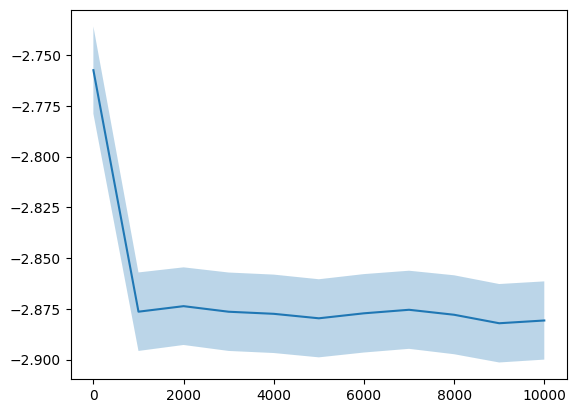

In [308]:
plt.plot(np.arange(E_avg_s.shape[0])*1000, E_avg_s)
plt.fill_between(np.arange(E_avg_s.shape[0])*1000, E_avg_s-E_std_s, E_avg_s+E_std_s, alpha=0.3)

In [311]:
N = 30000 # Todo: Change back to 30k
n = 1000
list_s = [0.1,1,10]

E_avg = []
E_std = []

for s_test in tqdm(list_s):
    simulation_s, P = metropolis_algorithm(R, N, s_test, alpha=0.15, beta=0.5, kappa=2, disable_tqdm=True)
    E_avg_s, E_std_s = energy_statistics(simulation_s, n, alpha=0.15, beta=0.5, kappa=2, disable_tqdm=True)
    E_avg.append(E_avg_s)
    E_std.append(E_std_s)

100%|██████████| 3/3 [06:43<00:00, 134.64s/it]


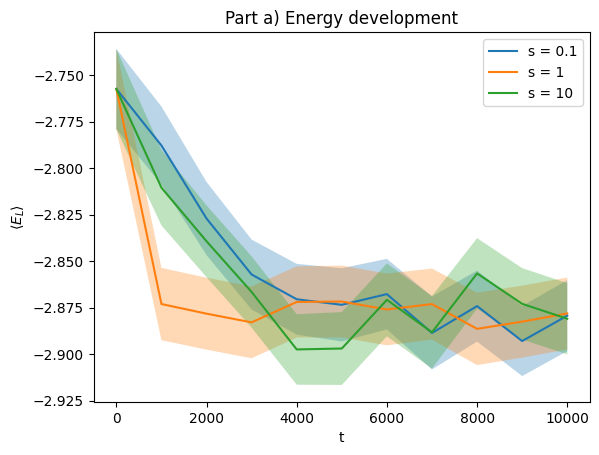

In [384]:
E_avg = np.array(E_avg)
E_std = np.array(E_std)

t = np.linspace(0,N,E_avg.shape[1])
for i in range(E_avg.shape[0]):
    plt.fill_between(t, E_avg[i]-E_std[i], E_avg[i]+E_std[i], alpha=0.3)
    plt.plot(t, E_avg[i], label=f"s = {list_s[i]}")
    
plt.title("Part a) Energy development")
plt.xlabel("t")
plt.ylabel(r"$\langle E_L \rangle$")
plt.legend()

In [313]:
E_avg = np.array(E_avg)
E_std = np.array(E_std)
print(pd.DataFrame({"s": list_s, "mean": E_avg[:,-1], "$\sigma$": E_std[:,-1]}))

      s      mean  $\sigma$
0   0.1 -2.879299  0.019101
1   1.0 -2.878122  0.019325
2  10.0 -2.880952  0.019139


# Problem b

In [335]:
N_b = 10000
list_alpha = [0.0, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]

E_avg_alpha = []
E_std_alpha = []

for a in tqdm(list_alpha):
    simulation_a, pa = metropolis_algorithm(R, num_trials=N_b, s=1, alpha=a, beta=0.5, kappa=2, disable_tqdm=True)
    E_avg_a, E_std_a = energy_statistics(simulation_a, n, alpha=a, beta=0.5, kappa=2, disable_tqdm=True)
    E_avg_alpha.append(E_avg_a)
    E_std_alpha.append(E_std_a)
    
E_avg_alpha = np.array(E_avg_alpha)
E_std_alpha = np.array(E_std_alpha)

100%|██████████| 7/7 [07:47<00:00, 66.76s/it]


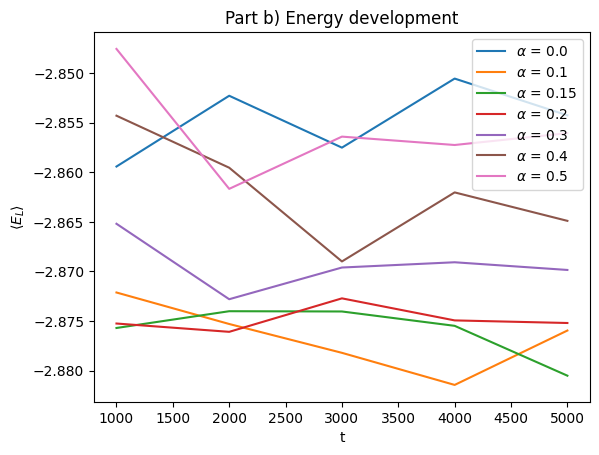

In [383]:
t_b = np.arange(1, E_std_alpha.shape[1])*1000
for i in range(len(list_alpha)):
    plt.plot(t_b, E_avg_alpha[i][1:], label= rf"$\alpha$ = {list_alpha[i]}")
    
plt.title("Part b) Energy development")
plt.xlabel("t")
plt.ylabel(r"$\langle E_L \rangle$")
plt.legend()

# Problem c

In [348]:
def energy_statistics_c(simulation, equilibration_time, alpha=0.15, beta=0.5, kappa=2, disable_tqdm=False): # Todo: If change in energy_statistics function is made, it may be necessary to change it here as well
    energies = []
    num_simulation_steps = simulation.shape[0]
    e_0 = [energy_local(simulation[0,i], simulation[0,i+M], alpha=alpha, beta=beta, kappa=kappa) for i in range(M)]
    for time in tqdm(range(equilibration_time, num_simulation_steps), disable=disable_tqdm):
        energies_t = []
        for i in range(M):
            e_i = energy_local(simulation[time,i], simulation[time,i+M], alpha=alpha, beta=beta, kappa=kappa)
            energies_t.append(e_i)
        energies.append(energies_t)
    e_avg_t = np.mean(energies)
    e_var_t = np.std(energies)
    return np.array(e_avg_t), np.array(e_var_t)

In [356]:
N_c = 10000 

In [357]:
n_equilibrium = 100 # Todo: Choose appropriate value

list_alpha_c = np.linspace(0,0.5,50)

E_avg_alpha_c = []
E_std_alpha_c = []

for alpha in tqdm(list_alpha_c):
    simulation_a, _ = metropolis_algorithm(R, N_c, s=1, alpha=alpha, beta=0.5, kappa=2, disable_tqdm=True)
    E_avg_a, E_std_a = energy_statistics_c(simulation_a, n_equilibrium, alpha=alpha, beta=0.5, kappa=2, disable_tqdm=True)
    E_avg_alpha_c.append(E_avg_a)
    E_std_alpha_c.append(E_std_a)
    
E_avg_alpha_c = np.array(E_avg_alpha_c)

100%|██████████| 50/50 [1:50:15<00:00, 132.31s/it]


Text(0.5, 1.0, 'Part c): Mean energy for different $\\alpha$')

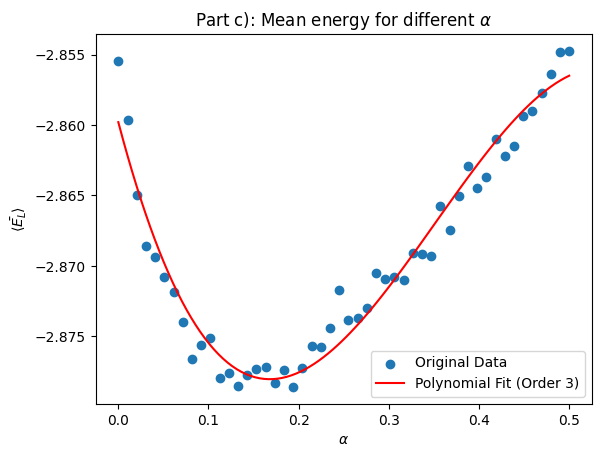

In [367]:
coefficients = np.polyfit(list_alpha_c, E_avg_alpha_c, 3)
polynomial_func = np.poly1d(coefficients)
x_fit = np.linspace(min(list_alpha_c), max(list_alpha_c), 100)
y_fit = polynomial_func(x_fit)

plt.scatter(list_alpha_c, E_avg_alpha_c, label='Original Data')
plt.plot(x_fit, y_fit, label='Polynomial Fit (Order 3)', color='red')
plt.legend()

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\langle \bar{E_{L}} \rangle$")
plt.title(r"Part c): Mean energy for different $\alpha$")

In [386]:
#Determining the alpha that minimizes the energy
alpha_min = np.round(list_alpha_c[np.argmin(E_avg_alpha_c)], 2)
alpha_min

0.19

In [370]:
print(E_avg_alpha_c)

[-2.85543227 -2.85961834 -2.86495057 -2.86862174 -2.86933802 -2.8707846
 -2.8718307  -2.87396813 -2.87659237 -2.87564114 -2.87512168 -2.87792743
 -2.87763444 -2.8785211  -2.87772355 -2.87730424 -2.87718414 -2.87832268
 -2.87740015 -2.87859209 -2.87724651 -2.87569669 -2.8757651  -2.87440855
 -2.87170826 -2.87385216 -2.87366565 -2.87295394 -2.87053189 -2.87095983
 -2.87076072 -2.87097531 -2.86909039 -2.86918373 -2.86931874 -2.86576749
 -2.86743191 -2.86500247 -2.86291363 -2.86444717 -2.86369765 -2.86099774
 -2.86218986 -2.86146718 -2.85933688 -2.85903564 -2.85775058 -2.85635683
 -2.85480065 -2.85473749]


In [368]:
coefficients

array([-0.90200444,  0.94959283, -0.2427015 , -2.85979314])

Text(0.5, 1.0, 'Part c): Mean energy for different $\\alpha$')

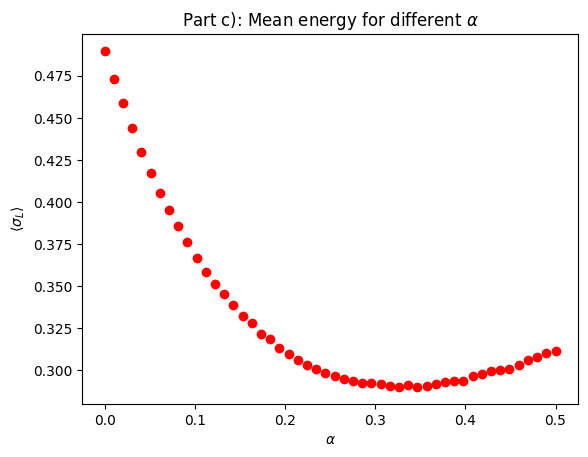

In [379]:
for i, alpha in enumerate(list_alpha_c):
    plt.plot(list_alpha_c[i], E_std_alpha_c[i], "ro", label = rf"$\alpha$ = {alpha}")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\langle \sigma_{L} \rangle$")
plt.title(r"Part c): Standard deviations for different $\alpha$")

In [388]:
print(E_std_alpha_c)

[array(0.48978086), array(0.47323631), array(0.45894377), array(0.44381361), array(0.42970736), array(0.4173527), array(0.40553939), array(0.39518825), array(0.38536951), array(0.37614989), array(0.36672923), array(0.35837218), array(0.35110362), array(0.34521349), array(0.33874036), array(0.33232694), array(0.32793083), array(0.32131672), array(0.31818107), array(0.31319876), array(0.30954297), array(0.30610529), array(0.30316253), array(0.30038649), array(0.29815058), array(0.29666601), array(0.29484927), array(0.29315348), array(0.29200644), array(0.29241767), array(0.29154553), array(0.29044466), array(0.29015954), array(0.29076183), array(0.28991522), array(0.29064097), array(0.29175186), array(0.29304857), array(0.29326544), array(0.29371693), array(0.2961504), array(0.29749525), array(0.29940107), array(0.29996014), array(0.30077475), array(0.30294928), array(0.30571645), array(0.30761967), array(0.31005186), array(0.31136929)]


# Problem d

In [354]:
alpha_optimal = alpha_min # Todo: repeat

list_kappa = np.linspace(1.7,2.2,50)

E_avg_kappa = []
E_std_kappa = []

for k in tqdm(list_kappa):
    simulation_k, _ = metropolis_algorithm(R, N_c, s=1, alpha=alpha_optimal, beta=0.5, kappa=k, disable_tqdm=True)
    E_avg_k, E_std_k = energy_statistics_c(simulation_k, n_equilibrium, disable_tqdm=True)
    E_avg_kappa.append(E_avg_k)
    E_std_kappa.append(E_std_k)

E_avg_kappa = np.array(E_avg_kappa)

100%|██████████| 50/50 [1:50:57<00:00, 133.14s/it]


Text(0.5, 1.0, 'Part d): Mean energy for different $\\kappa$')

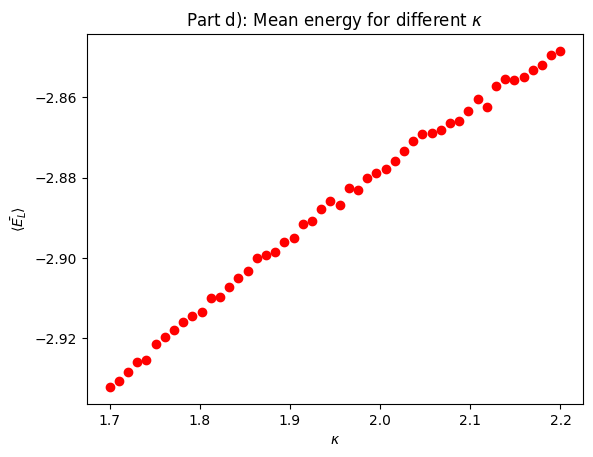

In [355]:
for i, k in enumerate(list_kappa):
    plt.plot(list_kappa[i], E_avg_kappa[i], "ro", label = rf"$\alpha$ = {k}")
plt.xlabel(r"$\kappa$")
plt.ylabel(r"$\langle \bar{E_{L}} \rangle$")
plt.title(r"Part d): Mean energy for different $\kappa$")

# Problem e

In [381]:
beta_e = 0.38
alpha_e = 0.18 
kappa_e = 1.85
simulation_e, _ = metropolis_algorithm(R, N_c, s=1, alpha=alpha_e, beta=beta_e, kappa=kappa_e)
E_avg_e, E_std_e = energy_statistics_c(simulation_e, n_equilibrium, disable_tqdm=True)

100%|██████████| 10000/10000 [01:41<00:00, 98.15it/s]


In [382]:
print(E_avg_e, E_std_e)

-2.9046102786525485 0.33534529688134523


In [76]:
E_exp = -2.90338583

In [ ]:
#Todo: Include problem f (analytical calculation)

# Problem g

In [394]:
list_delta_t = [0.01, 0.05, 0.1, 0.2, 1.0]
    
E_avg_dt = []
E_std_dt = []

for dt in tqdm(list_delta_t):
    simulation_dt, _ = metropolis_algorithm(R, 1000, 1, alpha_e, beta_e, kappa_e, use_FP = True, delta_t=dt, disable_tqdm=True)
    E_avg_t, E_std_t = energy_statistics_c(simulation_dt, n_equilibrium, alpha=alpha_e, beta=beta_e, kappa=kappa_e, disable_tqdm=True)
    E_avg_dt.append(E_avg_t)
    E_std_dt.append(E_std_t)
    
E_avg_dt = np.array(E_avg_dt)
E_std_dt = np.array(E_std_dt)

100%|██████████| 5/5 [03:26<00:00, 41.37s/it]


Text(0.5, 1.0, 'Part g): Standard deviations for different $\\Delta \\tau$')

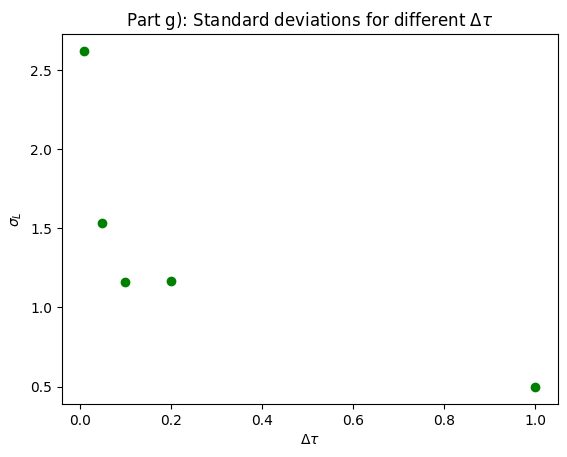

In [397]:
plt.plot(list_delta_t, E_std_dt, "go")
plt.xlabel(r"$\Delta \tau$")
plt.ylabel(r"$ \sigma_{L}$")
plt.title(r"Part g): Standard deviations for different $\Delta \tau$")

In [399]:
print(pd.DataFrame({r"time step": list_delta_t, "mean": E_std_dt, "standard deviation": E_std_dt}))

   time step      mean  standard deviation
0       0.01  2.622068            2.622068
1       0.05  1.532510            1.532510
2       0.10  1.159066            1.159066
3       0.20  1.165482            1.165482
4       1.00  0.497427            0.497427


# Problem h

 Plot the density of the electrons given by the Fokker–Planck VMC walkers (after
equilibration) in dependence of the radial distance r from the Helium nucleus. What
should be the limiting behaviour of this quantity? Moreover, plot the probability
distribution of the distances between the two electrons.|

In [ ]:
simulation_dt